In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Cambiar al directorio donde se encuentra el dataset
dataset_path = '/content/drive/My Drive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos'
os.listdir(dataset_path)  # Verifica los archivos en el directorio

Mounted at /content/drive


['readme.md',
 'Lexique - Data Analyst.xlsx',
 'extract - cash request - data analyst.csv',
 'extract - fees - data analyst - .csv',
 'extract - cash request - data analyst.gsheet',
 'extract - fees - data analyst - .gsheet',
 'payments_manager.py']

In [ ]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
credit_requests = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - cash request - data analyst.csv')
# Crear una copia del DataFrame para preservar el original
cr = credit_requests.copy()

# Cargar el dataset de tarifas o fees para análisis de cohortes de tarifas
fees = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')
# Crear una copia del DataFrame para preservar el original
fs = fees.copy()

In [ ]:
# Rellenar valores nulos en 'user_id' usando 'deleted_account_id' (clientes transferidos de cuentas eliminadas)
cr.fillna({"user_id": cr["deleted_account_id"]}, inplace=True)

In [ ]:
# Convertir 'created_at' a tipo datetime para manipulación de fechas
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr.head()

# Convertir la columna 'created_at' en fees a tipo datetime para análisis temporal
fs['created_at'] = pd.to_datetime(fs['created_at'])
fs.head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150+00:00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00:00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00:00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00:00,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,NaN,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00:00,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,NaN,after


In [ ]:
# Convertir la columna 'created_at' a una fecha sin zona horaria
cr['created_at'] = cr['created_at'].dt.tz_localize(None)
cr.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN


In [ ]:
# Crear columna 'Mes' indicando el mes de cada solicitud
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,Mes
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2020-05


In [ ]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
cr['Cohorte'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
cr.head(10)

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,Mes,Cohorte
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2020-05,2020-05
5,2145,100.0,money_back,2020-05-23 20:58:55.129432,2020-07-06 03:36:03.023911+00,9489.0,2020-05-24 12:40:33.05491+00,NaN,2020-06-06 22:00:00+00,2020-05-26,2020-07-06 03:36:03.023521+00,regular,NaN,completed,2020-06-12 22:27:04.837525+00,2020-07-06 03:36:03.030904+00,2020-05,2020-05
6,3512,100.0,rejected,2020-06-16 17:07:38.452652,2020-06-17 10:21:21.364746+00,14631.0,2020-06-17 10:21:21.360742+00,NaN,2020-07-11 23:51:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2020-06,2020-06
7,654,100.0,rejected,2020-02-10 01:11:53.808270,2020-02-10 11:53:32.104131+00,309.0,2020-02-10 09:11:21.350695+00,309.0,2020-03-11 01:11:53.80793+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2020-02,2020-01
8,5672,100.0,canceled,2020-06-28 12:06:33.712840,2020-06-28 12:06:33.712853+00,2499.0,NaN,2499.0,2020-07-07 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2020-06,2020-06
9,71,90.0,rejected,2019-12-10 19:51:23.911206,2019-12-12 15:06:11.192888+00,897.0,2019-12-12 15:06:11.190299+00,NaN,2019-12-17 19:51:23.910748+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12,2019-12


In [ ]:
# Calcular el número inicial de clientes únicos en cada cohorte
cohort_sizes_initial = cr.groupby('Cohorte').agg(Num_Clientes_Iniciales=('user_id', 'nunique')).reset_index()
cohort_sizes_initial

,Cohorte,Num_Clientes_Iniciales
0,2019-11,1
1,2019-12,254
2,2020-01,106
3,2020-02,90
4,2020-03,86
5,2020-04,246
6,2020-05,432
7,2020-06,1540
8,2020-07,1482
9,2020-08,728


In [ ]:
# Calcular la cantidad de clientes únicos en cada cohorte para cada mes
cohort_sizes_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Clientes=('user_id', 'nunique')).reset_index()
cohort_sizes_monthly

,Cohorte,Mes,Num_Clientes
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,680
79,2020-09,2020-11,20
80,2020-10,2020-10,4802
81,2020-10,2020-11,15


In [ ]:
# Agregar columnas de temporalidad
# Semana y mes de la solicitud
cr['Semana_Mes'] = cr['created_at'].dt.strftime('%U_%B') + '_' + cr['Mes'].dt.strftime('%Y')
# Día y semana de la solicitud
cr['Dia_Semana'] = cr['created_at'].dt.strftime('%A') + '_' + cr['Semana_Mes']
# Hora y dia de la solicitud
cr['Hora_Dia'] = cr['created_at'].dt.hour.astype(str) + '_' + cr['Dia_Semana']
cr.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,...,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,Mes,Cohorte,Semana_Mes,Dia_Semana,Hora_Dia
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,...,regular,NaN,NaN,NaN,NaN,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,...,regular,NaN,NaN,NaN,NaN,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,...,regular,NaN,NaN,NaN,NaN,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,...,regular,NaN,NaN,NaN,NaN,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,...,regular,NaN,NaN,NaN,NaN,2020-05,2020-05,18_May_2020,Wednesday_18_May_2020,9_Wednesday_18_May_2020


In [ ]:
# Calcular la cantidad de adelanto de efectivo por cohorte y mes
cohort_revenue = cr.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()
cohort_revenue = cohort_revenue.pivot(index='Cohorte', columns='Mes', values='amount')
cohort_revenue

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,100.0,NaN,NaN,NaN,100.0,10.0,NaN,NaN,10.0,5.0,6.0,NaN
2019-12,NaN,27197.0,10123.0,5881.0,7650.0,7900.0,8175.0,8805.0,6990.0,7790.0,4860.0,6655.0,100.0
2020-01,NaN,NaN,11464.0,2360.0,1660.0,3500.0,3020.0,2770.0,3010.0,2150.0,1970.0,2350.0,100.0
2020-02,NaN,NaN,NaN,8412.0,4740.0,4607.0,4350.0,4235.0,4405.0,4130.0,2555.0,3595.0,NaN
2020-03,NaN,NaN,NaN,NaN,9499.0,4250.0,4540.0,4850.0,4055.0,3390.0,2800.0,2700.0,50.0
2020-04,NaN,NaN,NaN,NaN,NaN,25736.0,14258.0,14320.0,11000.0,9915.0,7685.0,6450.0,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,44883.0,30143.0,25725.0,21224.0,16350.0,15305.0,350.0
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180903.0,92672.0,84491.0,60025.0,56525.0,400.0
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180330.0,76873.0,49725.0,47313.0,500.0


In [ ]:
# Calcular la tasa de retención de clientes (clientes únicos por cohorte en cada mes / clientes iniciales de la cohorte)
retention_clientes = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes', values='Num_Clientes')
retention_clientes = retention_clientes.div(cohort_sizes_initial.set_index('Cohorte')['Num_Clientes_Iniciales'], axis=0)
retention_clientes


# Agregar columnas de temporalidad
# Semana y mes de la solicitud
cr['Semana_Mes'] = cr['created_at'].dt.strftime('%U_%B') + '_' + cr['Mes'].dt.strftime('%Y')
# Día y semana de la solicitud
cr['Dia_Semana'] = cr['created_at'].dt.strftime('%A') + '_' + cr['Semana_Mes']
# Hora y dia de la solicitud
cr['Hora_Dia'] = cr['created_at'].dt.hour.astype(str) + '_' + cr['Dia_Semana']
cr.head()


# Calcular la cantidad de adelanto de efectivo por cohorte y mes
cohort_revenue = cr.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()
cohort_revenue = cohort_revenue.pivot(index='Cohorte', columns='Mes', values='amount')

cohort_revenue

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,100.0,NaN,NaN,NaN,100.0,10.0,NaN,NaN,10.0,5.0,6.0,NaN
2019-12,NaN,27197.0,10123.0,5881.0,7650.0,7900.0,8175.0,8805.0,6990.0,7790.0,4860.0,6655.0,100.0
2020-01,NaN,NaN,11464.0,2360.0,1660.0,3500.0,3020.0,2770.0,3010.0,2150.0,1970.0,2350.0,100.0
2020-02,NaN,NaN,NaN,8412.0,4740.0,4607.0,4350.0,4235.0,4405.0,4130.0,2555.0,3595.0,NaN
2020-03,NaN,NaN,NaN,NaN,9499.0,4250.0,4540.0,4850.0,4055.0,3390.0,2800.0,2700.0,50.0
2020-04,NaN,NaN,NaN,NaN,NaN,25736.0,14258.0,14320.0,11000.0,9915.0,7685.0,6450.0,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,44883.0,30143.0,25725.0,21224.0,16350.0,15305.0,350.0
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180903.0,92672.0,84491.0,60025.0,56525.0,400.0
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180330.0,76873.0,49725.0,47313.0,500.0


Precisión del modelo en datos de prueba: -5.4032


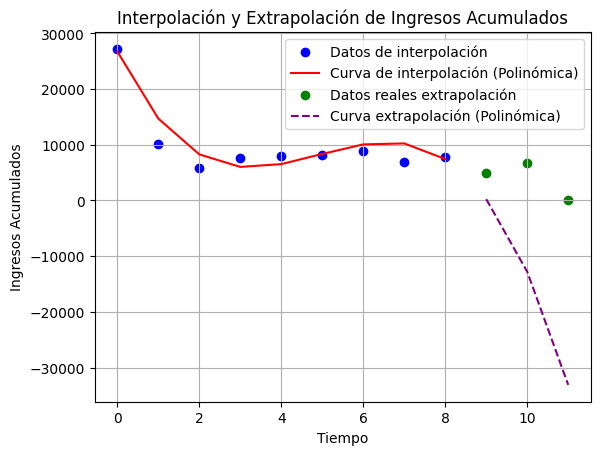

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
n_total = len(datos_no_nulos)

# División de los datos
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = np.array(range(len(datos_interpolacion))).reshape(-1, 1)
y_interpolacion = datos_interpolacion.values

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = np.array(range(n_interpolacion, n_total)).reshape(-1, 1)
y_extrapolacion = datos_extrapolacion.values

# Transformar los datos para ajustar un modelo polinómico de grado 3
poly = PolynomialFeatures(degree=3)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión polinómica y entrenarlo
modelo = LinearRegression()
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(x_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(x_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Polinómica)')

# Graficar los datos de extrapolación
plt.scatter(x_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(x_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Polinómica)')

# Configuración del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados')
plt.legend()
plt.grid()
plt.show()

Precisión del modelo en datos de prueba: 0.5589


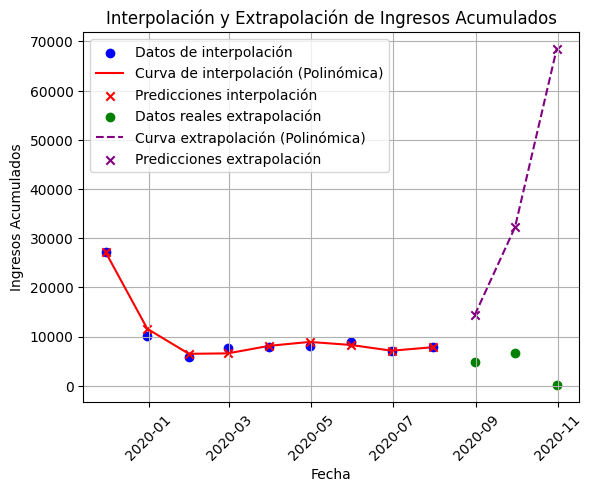

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión polinómica y entrenarlo
modelo = LinearRegression()
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Polinómica)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Polinómica)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo en datos de prueba (R^2): 0.5589
Error Cuadrático Medio (MSE): 1082446.0534
Raíz del Error Cuadrático Medio (RMSE): 1040.4067


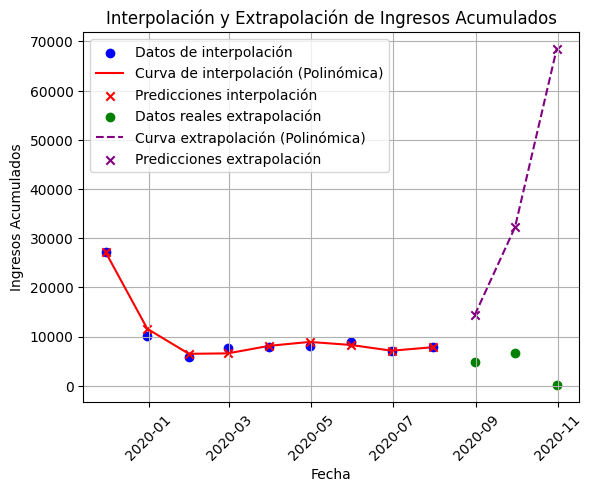

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Escalar los datos (opcional, puede mejorar la precisión en modelos polinómicos)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear el modelo de regresión polinómica y entrenarlo
modelo = LinearRegression()
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo en los datos de prueba
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo en datos de prueba (R^2): {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(scaler.transform(x_interpolacion))
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(scaler.transform(x_extrapolacion))
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el MSE
mse = mean_squared_error(y_test, modelo.predict(x_test_poly))
rmse = np.sqrt(mse)
print(f'Error Cuadrático Medio (MSE): {mse:.4f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}')

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Polinómica)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Polinómica)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Usando un polinomio de grado 3 con Ridge alpha=0.2
Precisión del modelo en datos de prueba (R^2): -5.4941
Error Cuadrático Medio (MSE): 15935978.2773
Raíz del Error Cuadrático Medio (RMSE): 3991.9893


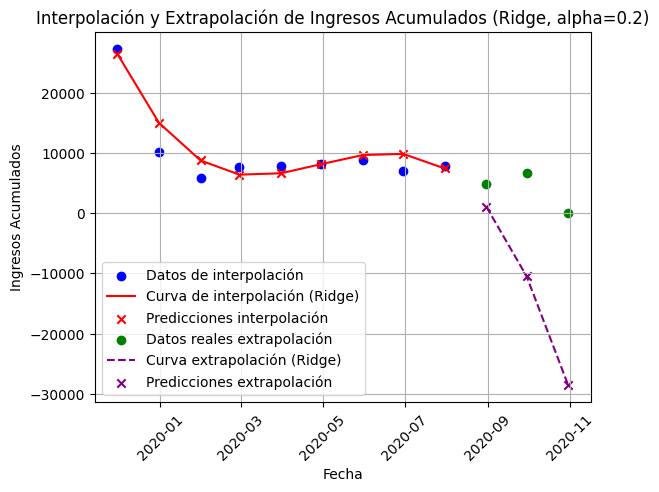

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge  # Importamos el modelo Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Configurar la variable alpha que define el rango de grados del polinomio
# Alpha se puede ajustar en pasos más pequeños, por ejemplo: 0.1, 0.2, ..., 10
# Haremos un mapeo entre alpha y el grado del polinomio.
alpha = 0.2  # Parámetro de regularización (puedes probar con 0.1, 1.0, 10.0, etc.)

# Convertir alpha a un grado de polinomio (por ejemplo: alpha=0.1 se convertirá a grado 1, alpha=0.2 a grado 2, etc.)
grado_polinomio = 3  # Ajuste directo del grado del polinomio, puedes cambiarlo si lo deseas

print(f'Usando un polinomio de grado {grado_polinomio} con Ridge alpha={alpha}')

# Escalar los datos (opcional, puede mejorar la precisión en modelos polinómicos)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Transformar los datos para ajustar un modelo polinómico con el grado definido por alpha
poly = PolynomialFeatures(degree=grado_polinomio)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear el modelo de Ridge Regression y entrenarlo
modelo_ridge = Ridge(alpha=alpha)  # Usamos Ridge en lugar de LinearRegression
modelo_ridge.fit(x_train_poly, y_train)

# Evaluar el modelo en los datos de prueba
score = modelo_ridge.score(x_test_poly, y_test)
print(f'Precisión del modelo en datos de prueba (R^2): {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(scaler.transform(x_interpolacion))
predicciones_interpolacion = modelo_ridge.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(scaler.transform(x_extrapolacion))
predicciones_extrapolacion = modelo_ridge.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (MSE) y el RMSE
mse = mean_squared_error(y_test, modelo_ridge.predict(x_test_poly))
rmse = np.sqrt(mse)
print(f'Error Cuadrático Medio (MSE): {mse:.4f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}')

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title(f'Interpolación y Extrapolación de Ingresos Acumulados (Ridge, alpha={alpha})')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


# **SEMI DEF**

Precisión del modelo Ridge en datos de prueba: -2.4960


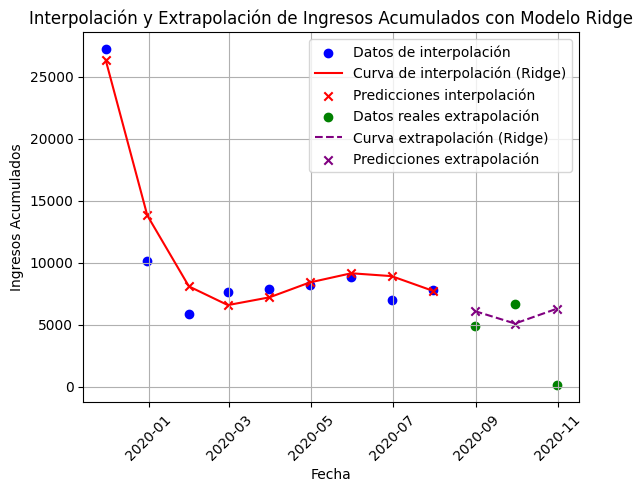

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge  # Importamos el modelo Ridge en lugar de LinearRegression
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.042)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo Ridge en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


## ESTANDARIZACIÓN

Precisión del modelo Ridge en datos de prueba: 0.5053


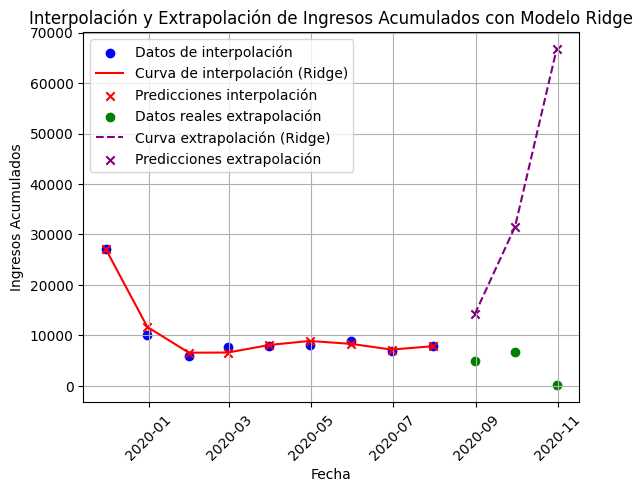

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge  # Importamos el modelo Ridge en lugar de LinearRegression
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Estandarizar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_interpolacion_scaled = scaler.transform(x_interpolacion)
x_extrapolacion_scaled = scaler.transform(x_extrapolacion)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.009)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo Ridge en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion_scaled)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion_scaled)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

R^^2

R^2 para los datos de entrenamiento: 0.9928
Diferencia (delta) entre las predicciones y los valores reales en entrenamiento: [-711.26243114   69.34631519  -57.25457896 -673.11247994 -192.11847834
 1060.84314608  503.5585071 ]


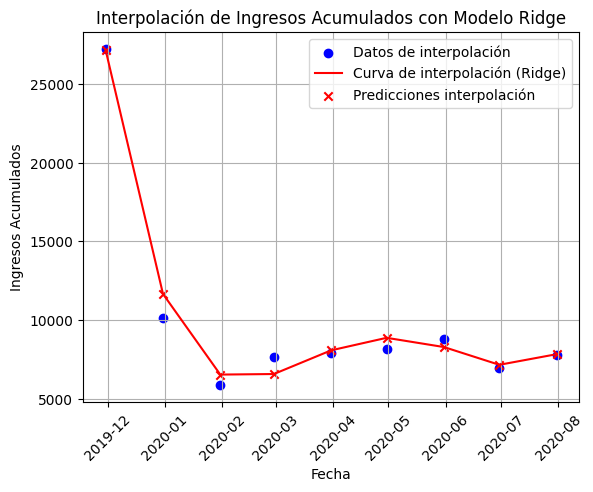

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score  # Importamos r2_score para calcular R^2

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_interpolacion_scaled = scaler.transform(x_interpolacion)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.009)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Predicciones en el conjunto de entrenamiento
y_train_pred = modelo.predict(x_train_poly)

# Calcular R^2 para los datos de entrenamiento
r2_train = r2_score(y_train, y_train_pred)
print(f'R^2 para los datos de entrenamiento: {r2_train:.4f}')

# Calcular la diferencia (delta) entre las predicciones y los valores reales en entrenamiento
delta = y_train - y_train_pred
print(f'Diferencia (delta) entre las predicciones y los valores reales en entrenamiento: {delta}')

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, modelo.predict(poly.transform(x_interpolacion_scaled)), color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, modelo.predict(poly.transform(x_interpolacion_scaled)), color='red', marker='x', label='Predicciones interpolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## **Modelos Lasso y Ridge despues de estandarización**

Precisión del modelo Ridge en datos de prueba: 0.0230
Precisión del modelo Lasso en datos de prueba: 0.5571


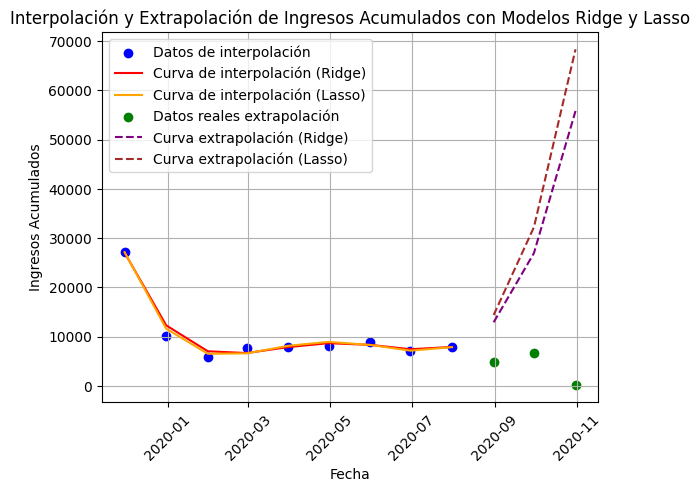

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge, Lasso  # Importamos los modelos Ridge y Lasso
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Estandarizar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_interpolacion_scaled = scaler.transform(x_interpolacion)
x_extrapolacion_scaled = scaler.transform(x_extrapolacion)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear los modelos de regresión Ridge y Lasso
modelo_ridge = Ridge(alpha=0.1)
modelo_lasso = Lasso(alpha=0.1)

# Entrenar los modelos
modelo_ridge.fit(x_train_poly, y_train)
modelo_lasso.fit(x_train_poly, y_train)

# Evaluar los modelos
score_ridge = modelo_ridge.score(x_test_poly, y_test)
score_lasso = modelo_lasso.score(x_test_poly, y_test)
print(f'Precisión del modelo Ridge en datos de prueba: {score_ridge:.4f}')
print(f'Precisión del modelo Lasso en datos de prueba: {score_lasso:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion_scaled)
predicciones_interpolacion_ridge = modelo_ridge.predict(x_interpolacion_poly)
predicciones_interpolacion_lasso = modelo_lasso.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion_scaled)
predicciones_extrapolacion_ridge = modelo_ridge.predict(x_extrapolacion_poly)
predicciones_extrapolacion_lasso = modelo_lasso.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion_ridge, color='red', label='Curva de interpolación (Ridge)')
plt.plot(fechas_interpolacion, predicciones_interpolacion_lasso, color='orange', label='Curva de interpolación (Lasso)')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion_ridge, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion_lasso, color='brown', linestyle='--', label='Curva extrapolación (Lasso)')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelos Ridge y Lasso')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo Ridge en datos de prueba: 0.3160
Precisión del modelo Lasso en datos de prueba: 0.5582


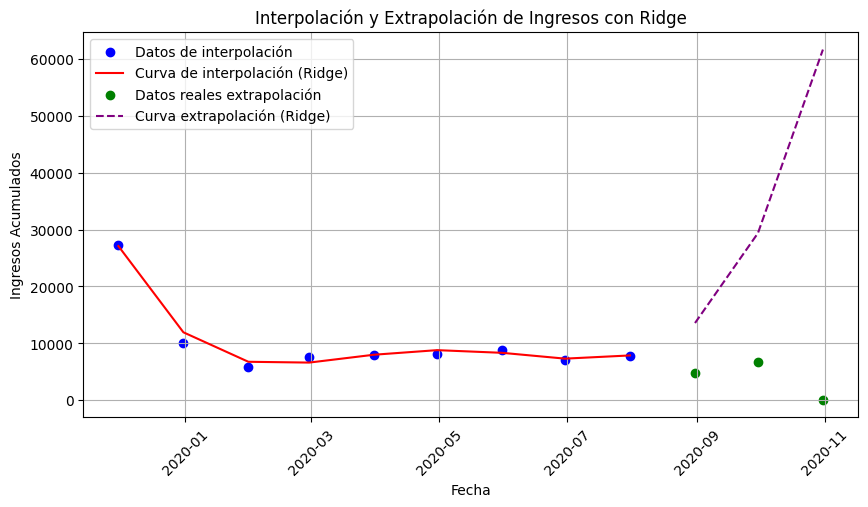

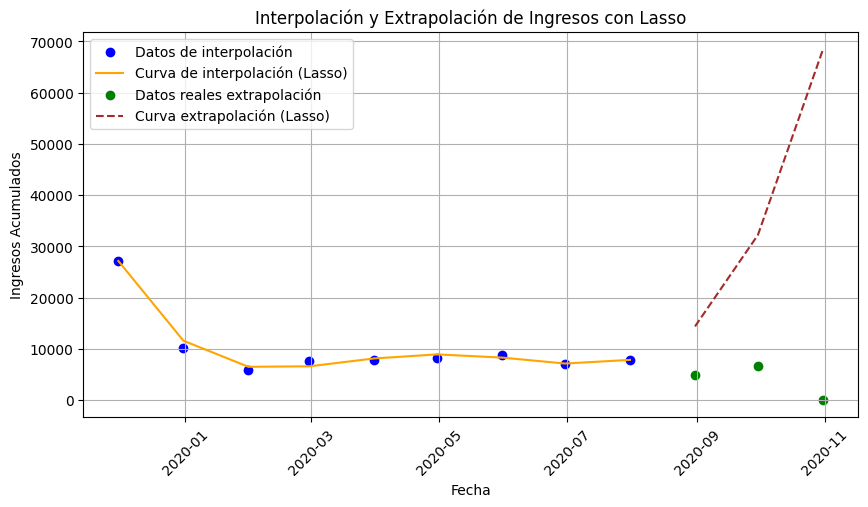

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge, Lasso  # Importamos los modelos Ridge y Lasso
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes
# Seleccionamos los datos de la cohorte 2019-12
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Estandarizar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_interpolacion_scaled = scaler.transform(x_interpolacion)
x_extrapolacion_scaled = scaler.transform(x_extrapolacion)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear los modelos de regresión Ridge y Lasso
modelo_ridge = Ridge(alpha=0.042)
modelo_lasso = Lasso(alpha=0.042)

# Entrenar los modelos
modelo_ridge.fit(x_train_poly, y_train)
modelo_lasso.fit(x_train_poly, y_train)

# Evaluar los modelos
score_ridge = modelo_ridge.score(x_test_poly, y_test)
score_lasso = modelo_lasso.score(x_test_poly, y_test)
print(f'Precisión del modelo Ridge en datos de prueba: {score_ridge:.4f}')
print(f'Precisión del modelo Lasso en datos de prueba: {score_lasso:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion_scaled)
predicciones_interpolacion_ridge = modelo_ridge.predict(x_interpolacion_poly)
predicciones_interpolacion_lasso = modelo_lasso.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion_scaled)
predicciones_extrapolacion_ridge = modelo_ridge.predict(x_extrapolacion_poly)
predicciones_extrapolacion_lasso = modelo_lasso.predict(x_extrapolacion_poly)

# Graficar Ridge
plt.figure(figsize=(10,5))
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion_ridge, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion_ridge, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos con Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Graficar Lasso
plt.figure(figsize=(10,5))
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion_lasso, color='orange', label='Curva de interpolación (Lasso)')
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion_lasso, color='brown', linestyle='--', label='Curva extrapolación (Lasso)')
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos con Lasso')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo Ridge en datos de prueba: -2.4960
MSE en datos de interpolación: 2728978.3458
RMSE en datos de interpolación: 1651.9620
MSE en datos de extrapolación: 14004765.5536
RMSE en datos de extrapolación: 3742.2942


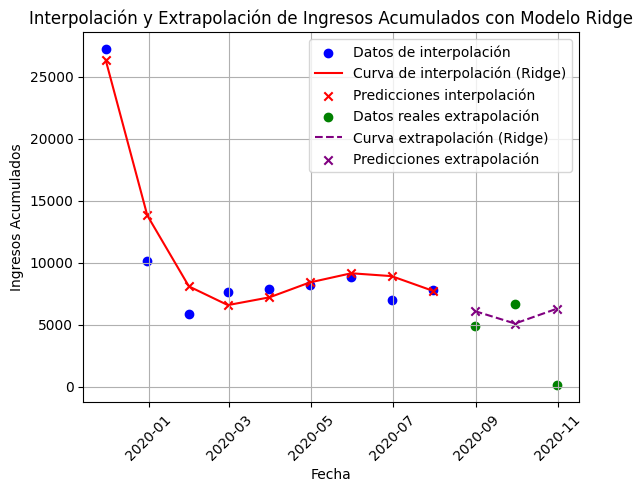

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  # Importamos la función para calcular MSE y RMSE

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.042)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo Ridge en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo (R²) en datos de prueba: -2.4960
MSE en datos de interpolación: 2728978.3458
RMSE en datos de interpolación: 1651.9620
MSE en datos de extrapolación: 14004765.5536
RMSE en datos de extrapolación: 3742.2942


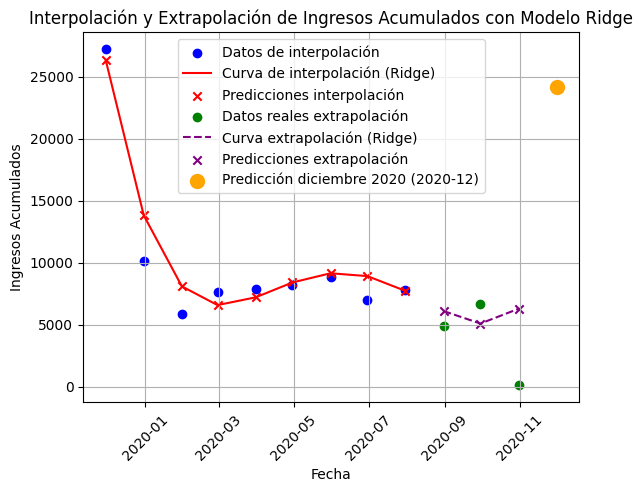

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.042)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo (R²) en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# --- Predicción para diciembre de 2020 ---
fecha_objetivo = pd.Timestamp('2020-12-01')

# Calcular el índice correspondiente a diciembre de 2020
indice_objetivo = len(datos_no_nulos) + (fecha_objetivo - fechas[-1]).days // 30

# Transformar el índice con el polinomio
indice_objetivo_poly = poly.transform([[indice_objetivo]])

# Realizar la predicción para diciembre de 2020
prediccion_diciembre_2020 = modelo.predict(indice_objetivo_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Graficar la predicción de diciembre 2020
plt.scatter(fecha_objetivo, prediccion_diciembre_2020, color='orange', s=100, zorder=5, label=f'Predicción diciembre 2020 (2020-12)')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo (R²) en datos de prueba: -2.4960
MSE en datos de interpolación: 2728978.3458
RMSE en datos de interpolación: 1651.9620
MSE en datos de extrapolación: 14004765.5536
RMSE en datos de extrapolación: 3742.2942


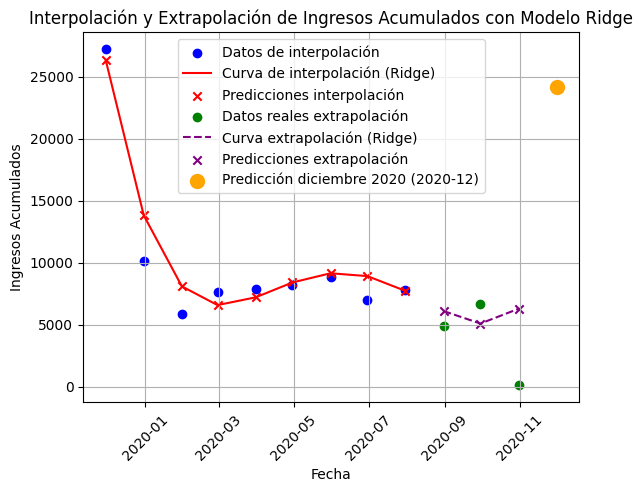

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos -1), freq='M')

# División de los datos
n_total = len(datos_no_nulos -1)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.042)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo (R²) en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# --- Predicción para diciembre de 2020 ---
fecha_objetivo = pd.Timestamp('2020-12-01')

# Calcular el índice correspondiente a diciembre de 2020
indice_objetivo = len(datos_no_nulos) + (fecha_objetivo - fechas[-1]).days // 30

# Transformar el índice con el polinomio
indice_objetivo_poly = poly.transform([[indice_objetivo]])

# Realizar la predicción para diciembre de 2020
prediccion_diciembre_2020 = modelo.predict(indice_objetivo_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Graficar la predicción de diciembre 2020
plt.scatter(fecha_objetivo, prediccion_diciembre_2020, color='orange', s=100, zorder=5, label=f'Predicción diciembre 2020 (2020-12)')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
cohorte_2019_12 = cohort_revenue.loc['2019-12':'2020-10']

Precisión del modelo (R²) en datos de prueba: -1.8485
MSE en datos de interpolación: 946577.3032
RMSE en datos de interpolación: 972.9220
MSE en datos de extrapolación: 4780106.1344
RMSE en datos de extrapolación: 2186.3454


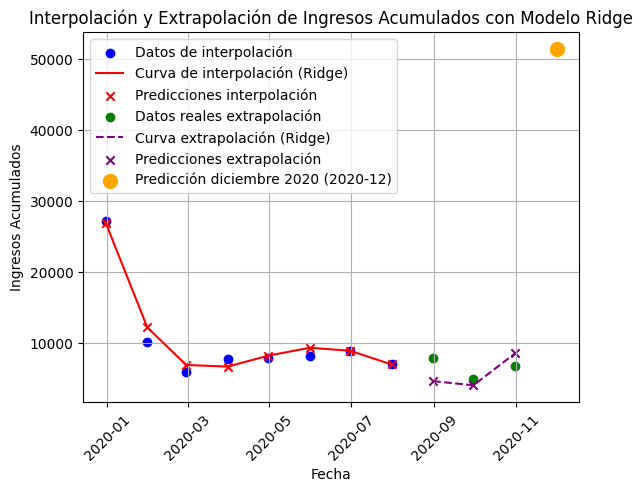

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Filtrar los datos entre 2019-12 y 2020-10
datos_filtrados = cohorte_2019_12.loc['2019-12':'2020-10']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = datos_filtrados.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-12', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.01)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo (R²) en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# --- Predicción para diciembre de 2020 ---
fecha_objetivo = pd.Timestamp('2020-12-01')

# Calcular el índice correspondiente a diciembre de 2020
indice_objetivo = len(datos_no_nulos) + (fecha_objetivo - fechas[-1]).days // 30

# Transformar el índice con el polinomio
indice_objetivo_poly = poly.transform([[indice_objetivo]])

# Realizar la predicción para diciembre de 2020
prediccion_diciembre_2020 = modelo.predict(indice_objetivo_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Graficar la predicción de diciembre 2020
plt.scatter(fecha_objetivo, prediccion_diciembre_2020, color='orange', s=100, zorder=5, label=f'Predicción diciembre 2020 (2020-12)')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo (R²) en datos de prueba: -2.1227
MSE en datos de interpolación: 1036591.0476
RMSE en datos de interpolación: 1018.1312
MSE en datos de extrapolación: 6816137.3104
RMSE en datos de extrapolación: 2610.7733


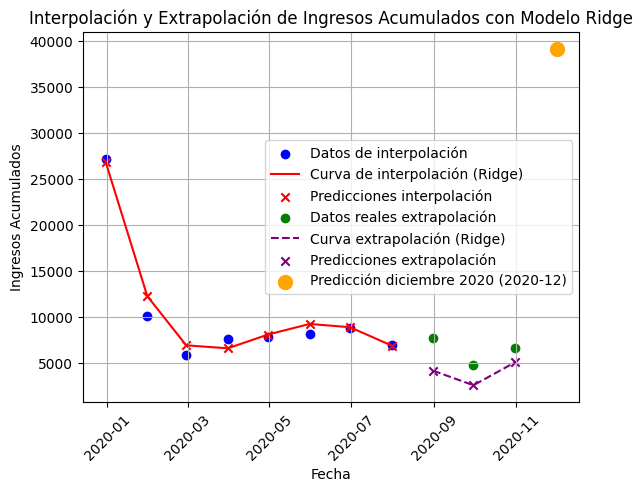

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Filtrar los datos entre 2019-12 y 2020-10
datos_filtrados = cohorte_2019_12.loc['2019-12':'2020-10']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = datos_filtrados.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-12', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.0116)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo (R²) en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# --- Predicción para diciembre de 2020 ---
fecha_objetivo = pd.Timestamp('2020-12-01')

# Calcular el índice correspondiente a diciembre de 2020
indice_objetivo = len(datos_no_nulos) + (fecha_objetivo - fechas[-1]).days // 30

# Transformar el índice con el polinomio
indice_objetivo_poly = poly.transform([[indice_objetivo]])

# Realizar la predicción para diciembre de 2020
prediccion_diciembre_2020 = modelo.predict(indice_objetivo_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Graficar la predicción de diciembre 2020
plt.scatter(fecha_objetivo, prediccion_diciembre_2020, color='orange', s=100, zorder=5, label=f'Predicción diciembre 2020 (2020-12)')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()